# Generate ice cream sales data

Generate ice cream sales data in the Netherlands (fictitious, of course).

The idea is to generate sales figures that can be predicted linearly from the average temperature, but only for days on which the number of hours of sunlight was greater than  6 and only in summer (May, June, July and August)

The base sales figure for ice cream is determined as follows:

- Unilever's ice cream division turned over 7.9 billion Euros.
- Assume Unilever sells ice cream for 1 Euro per liter (reasonable - supermarkets and other points of sale also need to make a profit).
- Assume more ice cream is sold in summer (May, June, July, August) than in the rest of the year.

Ice cream sales will be given in 1k litres

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For testing our work
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
###############################################################################
#                                                                             #
# Settings. By all means change these to see if that yields better results.   #
#                                                                             #
###############################################################################

summer_coefficient = 0.03 # How much more ice cream is sold in summer?
                         # Note: higher values make the desired effect (more ice cream sold on sunny days) more difficult to see.
min_num_hrs_sunlight = 7 # The threshold (num hours of sunlight) before the linear effect kicks in.

summer_months = [5, 6, 7, 8] # Which months are considered to be summer?

noise_coefficient = 0.3 # How much of the sales data should be noise?

linear_effect_strength = 0.4 # How strong should the effect be?

total_ice_cream_sold_kl = 7900000000 / 1000 # 1000s of litres of ice cream sold in a year.

## Read in weather data and add base ice cream sales data to it.


In [3]:
# Read in weather data
df = pd.read_csv('data/src/knmi-processed.csv')
# Make sure dates are interpreted as, well, dates
df['date'] = pd.to_datetime(df['date'])
df


,date,temp_avg,temp_min,temp_max,sun_hr,rain_hr,rain_total_mm,cloud_cover_perc
0,2022-01-01,12.3,10.9,13.2,1.7,1.0,0.3,1.000
1,2022-01-02,11.7,10.2,13.0,1.0,5.2,13.2,1.000
2,2022-01-03,9.7,8.8,11.0,2.3,0.0,0.0,0.875
3,2022-01-04,6.5,3.2,8.9,0.9,0.7,0.3,0.875
4,2022-01-05,5.1,2.3,7.6,0.5,5.5,5.4,0.625
...,...,...,...,...,...,...,...,...
1091,2024-12-27,2.5,-0.1,4.2,1.1,0.0,0.0,0.875
1092,2024-12-28,1.0,-0.2,2.7,0.0,0.0,0.0,1.000
1093,2024-12-29,4.0,2.7,5.1,0.0,4.5,0.7,1.000
1094,2024-12-30,6.9,4.6,8.2,0.0,1.1,0.2,1.000


In [4]:
# Add extra columns that mark records as "summer" and "enough sun".
# This makes our work further on a bit easier.
df['summer'] = False
df.loc[df['date'].dt.month.isin(summer_months), 'summer'] = True

df['enough_sun'] = False
df.loc[df['sun_hr'] >= min_num_hrs_sunlight, 'enough_sun'] = True

In [5]:
# Add ice cream sales data.
kl_day = total_ice_cream_sold_kl / 365
kl_day_summer = kl_day * (1 + summer_coefficient)
kl_day_non_summer = kl_day * (1 - summer_coefficient)
df['ice_cream_kl'] = kl_day_non_summer
df.loc[df['summer'] == True, 'ice_cream_kl'] = kl_day_summer



In [6]:
# Add noise.
noise = np.random.normal(loc=0.5, scale=0.1, size = len(df))
df['ice_cream_kl_noise'] = df['ice_cream_kl'] * (1 - noise_coefficient) + df['ice_cream_kl'] * noise * noise_coefficient



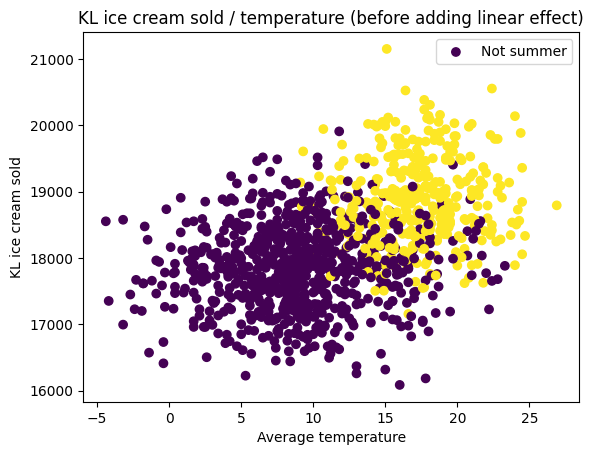

In [7]:
# Show what we have now
plt.scatter(df['temp_avg'], df['ice_cream_kl_noise'], c=df['summer'])
plt.legend(['Not summer'])
plt.title('KL ice cream sold / temperature (before adding linear effect)')
plt.ylabel('KL ice cream sold')
plt.xlabel('Average temperature')
plt.show()

## Add a linear effect based on temperature


In [8]:
# Scale temperatures to between 0 and 1 (min max scaling)
df['temp_avg_scaled'] = (df['temp_avg'] - df['temp_avg'].min()) / (df['temp_avg'].max() - df['temp_avg'].min())
df['ice_cream_kl_temp'] = df['ice_cream_kl_noise']
df.loc[df['enough_sun'] == True, 'ice_cream_kl_temp'] = df.apply(lambda row :
                                                                 row['ice_cream_kl_noise'] * row['temp_avg_scaled'] * linear_effect_strength +
                                                                 row['ice_cream_kl_noise'] * (1 - linear_effect_strength) +
                                                                 # This last bit below is a HACK to get the values around the same magnitude as the values to which the effect is not applied.
                                                                 row['ice_cream_kl_noise'] * linear_effect_strength, axis = 1)
df

,date,temp_avg,temp_min,temp_max,sun_hr,rain_hr,rain_total_mm,cloud_cover_perc,summer,enough_sun,ice_cream_kl,ice_cream_kl_noise,temp_avg_scaled,ice_cream_kl_temp
0,2022-01-01,12.3,10.9,13.2,1.7,1.0,0.3,1.000,False,False,20994.520548,17997.260870,0.533546,17997.260870
1,2022-01-02,11.7,10.2,13.0,1.0,5.2,13.2,1.000,False,False,20994.520548,16956.770738,0.514377,16956.770738
2,2022-01-03,9.7,8.8,11.0,2.3,0.0,0.0,0.875,False,False,20994.520548,17135.989285,0.450479,17135.989285
3,2022-01-04,6.5,3.2,8.9,0.9,0.7,0.3,0.875,False,False,20994.520548,18983.091149,0.348243,18983.091149
4,2022-01-05,5.1,2.3,7.6,0.5,5.5,5.4,0.625,False,False,20994.520548,17822.756086,0.303514,17822.756086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2024-12-27,2.5,-0.1,4.2,1.1,0.0,0.0,0.875,False,False,20994.520548,18849.132381,0.220447,18849.132381
1092,2024-12-28,1.0,-0.2,2.7,0.0,0.0,0.0,1.000,False,False,20994.520548,17477.446333,0.172524,17477.446333
1093,2024-12-29,4.0,2.7,5.1,0.0,4.5,0.7,1.000,False,False,20994.520548,17804.295568,0.268371,17804.295568
1094,2024-12-30,6.9,4.6,8.2,0.0,1.1,0.2,1.000,False,False,20994.520548,16825.225245,0.361022,16825.225245


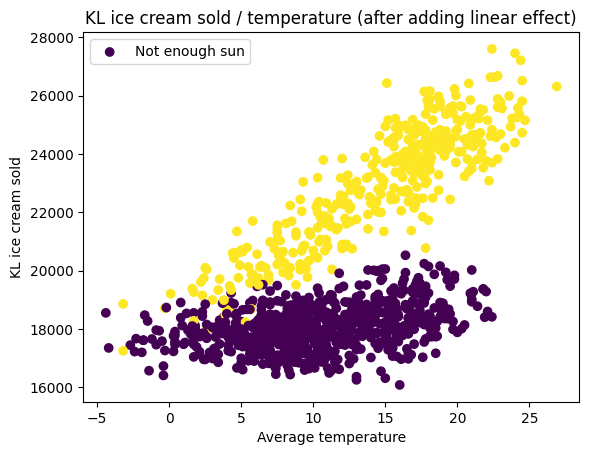

In [9]:
# Again, show what we have now
plt.scatter(df['temp_avg'], df['ice_cream_kl_temp'], c=df['enough_sun'])
plt.legend(['Not enough sun'])
plt.title('KL ice cream sold / temperature (after adding linear effect)')
plt.ylabel('KL ice cream sold')
plt.xlabel('Average temperature')
plt.show()

In [10]:
# Test the R^2 scores for a linear model.
df_enough_sunlight = df[df['enough_sun']]
model_enough_sunlight = LinearRegression()
model_enough_sunlight.fit(df_enough_sunlight[['temp_avg']], df_enough_sunlight[['ice_cream_kl_temp']])
enough_sunlight_score = model_enough_sunlight.score(df_enough_sunlight[['temp_avg']], df_enough_sunlight[['ice_cream_kl_temp']])
print(f'A linear model for days with > {min_num_hrs_sunlight} hours of sunlight has an R2 of {enough_sunlight_score:.2f}')

model_not_enough_sunlight = LinearRegression()
model_not_enough_sunlight.fit(df[['temp_avg']], df[['ice_cream_kl_temp']])
not_enough_sunlight_score = model_not_enough_sunlight.score(df[['temp_avg']], df[['ice_cream_kl_temp']])
print(f'A linear model for days with <= {min_num_hrs_sunlight} hours of sunlight has an R2 of {not_enough_sunlight_score:.2f}')




A linear model for days with > 7 hours of sunlight has an R2 of 0.79
A linear model for days with <= 7 hours of sunlight has an R2 of 0.37


## Done

If the results above are to our liking, we can save the dataset (to data/ice_cream_sales)

In [11]:
df_final = df.drop(columns=['summer', 'enough_sun', 'ice_cream_kl', 'ice_cream_kl_noise', 'temp_avg_scaled']).copy()
df_final.rename(columns={'ice_cream_kl_temp' : 'ice_cream_kl'}, inplace=True)
df_final['ice_cream_kl'] = df_final['ice_cream_kl'].round().astype('int')
df_final.to_csv('data/ice_cream_sales.csv', index=False)
df_final

,date,temp_avg,temp_min,temp_max,sun_hr,rain_hr,rain_total_mm,cloud_cover_perc,ice_cream_kl
0,2022-01-01,12.3,10.9,13.2,1.7,1.0,0.3,1.000,17997
1,2022-01-02,11.7,10.2,13.0,1.0,5.2,13.2,1.000,16957
2,2022-01-03,9.7,8.8,11.0,2.3,0.0,0.0,0.875,17136
3,2022-01-04,6.5,3.2,8.9,0.9,0.7,0.3,0.875,18983
4,2022-01-05,5.1,2.3,7.6,0.5,5.5,5.4,0.625,17823
...,...,...,...,...,...,...,...,...,...
1091,2024-12-27,2.5,-0.1,4.2,1.1,0.0,0.0,0.875,18849
1092,2024-12-28,1.0,-0.2,2.7,0.0,0.0,0.0,1.000,17477
1093,2024-12-29,4.0,2.7,5.1,0.0,4.5,0.7,1.000,17804
1094,2024-12-30,6.9,4.6,8.2,0.0,1.1,0.2,1.000,16825
